C:\Users\ninar\AppData\Local\Temp\ipykernel_11000\1490440392.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


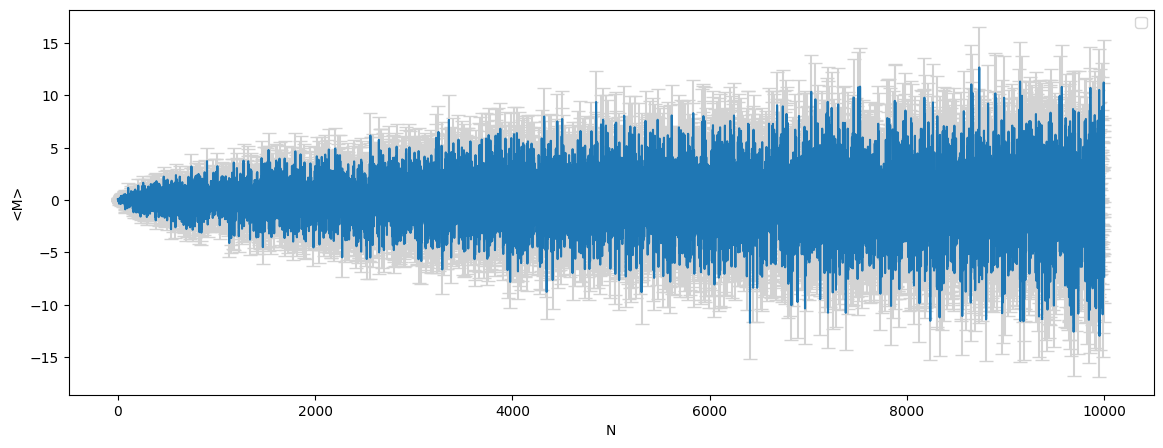

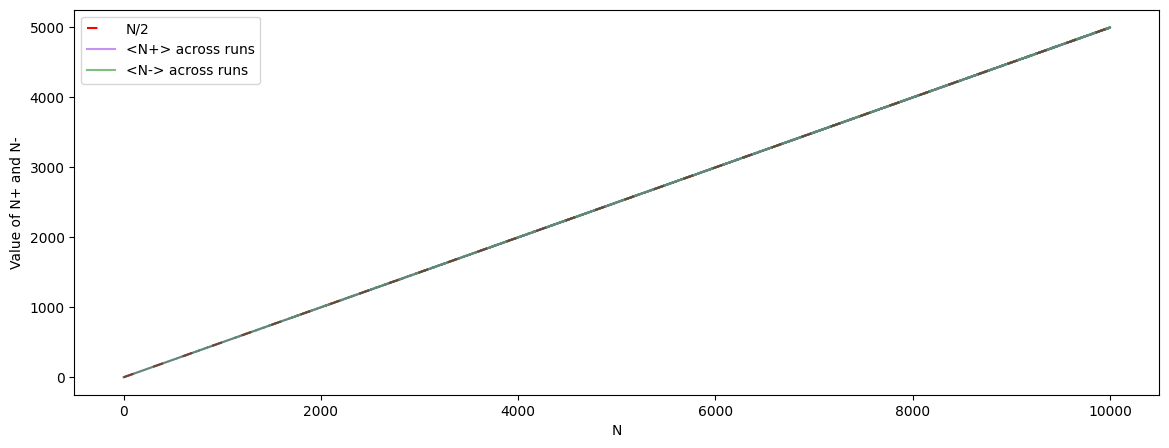

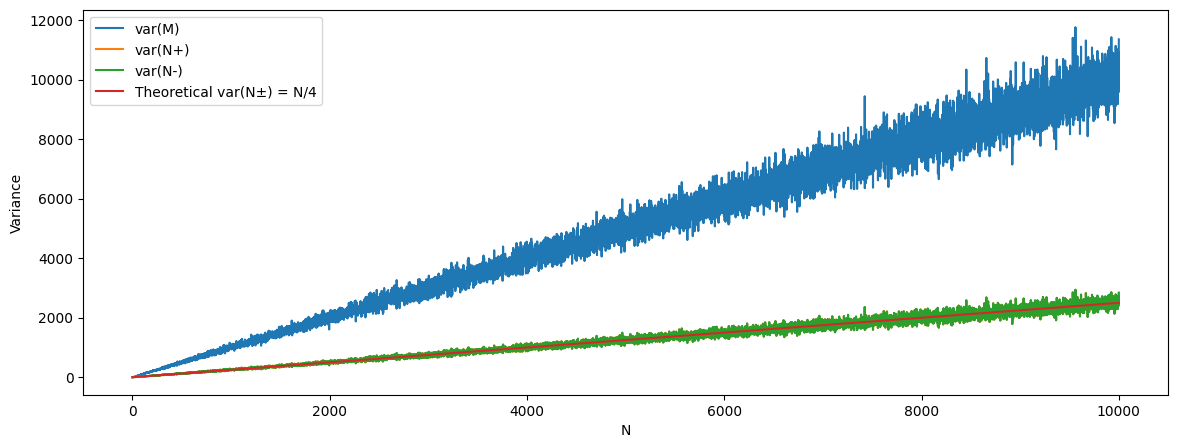

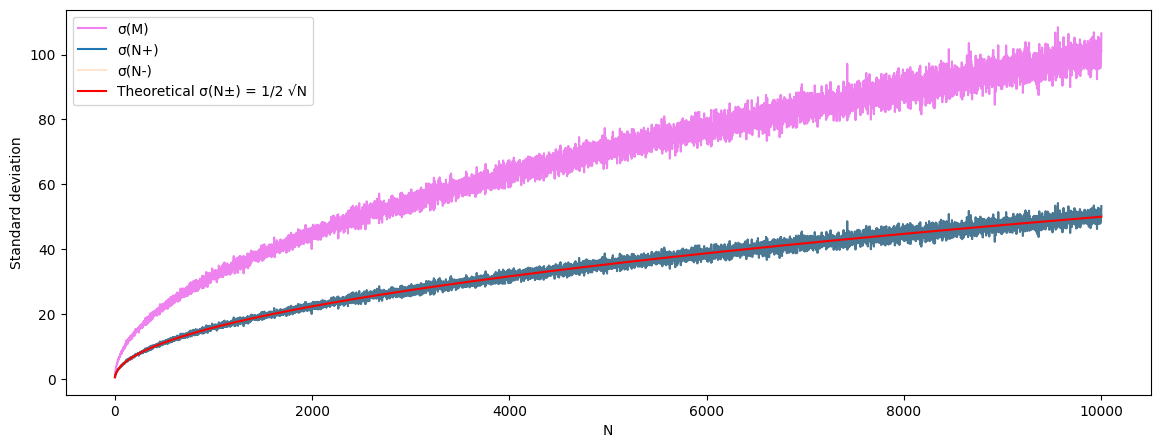

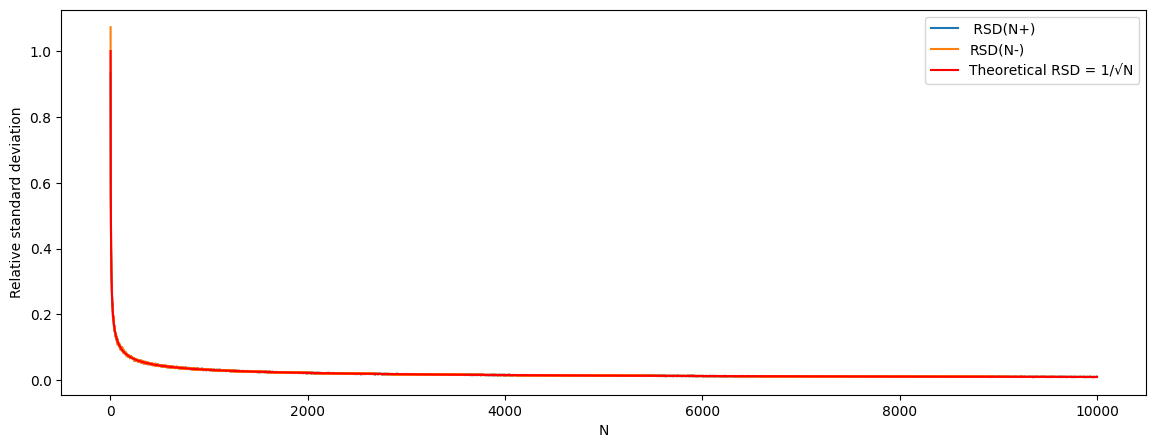

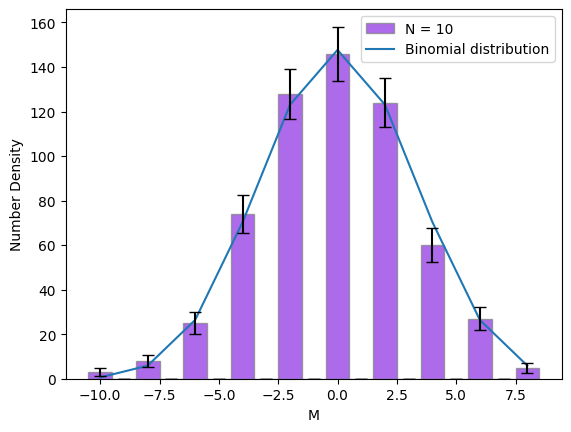

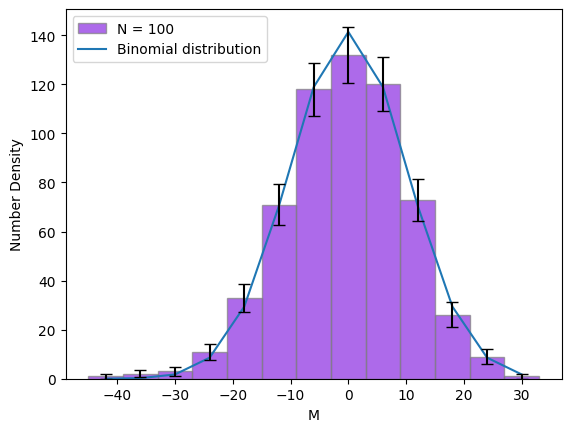

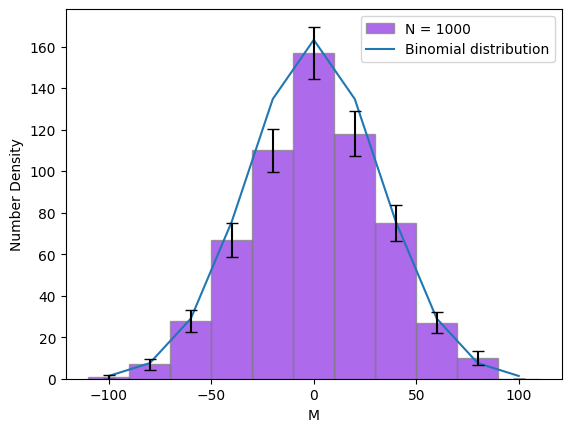

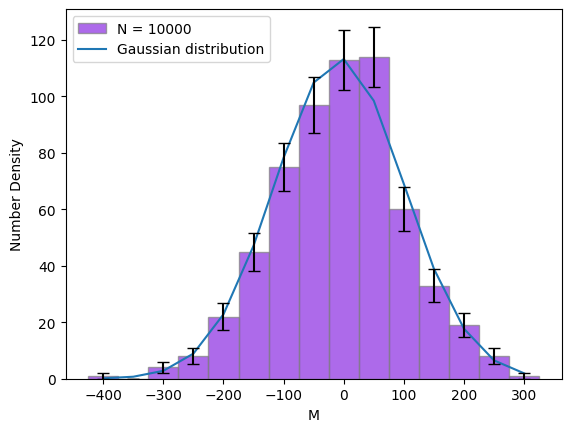

array([  1.,   0.,   4.,   8.,  22.,  45.,  75.,  97., 113., 114.,  60.,
        33.,  19.,   8.,   1.])

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import math 

data = np.load('./data_example_1_600_runs_10000_particles.npz')

N = data['N']

all_M_values = data['all_M_values']
avg_M = np.mean(all_M_values, axis = 0) #along columns

N_plus = (all_M_values+N)/2
avg_N_plus = np.mean(N_plus, axis = 0)

N_minus = (N - all_M_values)/2
avg_N_min = np.mean(N_minus, axis = 0)


std_M = np.std(all_M_values, axis = 0) #along columns 

std_N_plus = np.std(N_plus, axis = 0)

std_N_min = np.std(N_minus, axis = 0)

var_M = std_M **2 
var_N_plus = std_N_plus**2
var_N_min = std_N_min **2 

relative_std_plus = std_N_plus/avg_N_plus
relative_std_min =std_N_min/avg_N_min 

f = lambda x: x/2

g = lambda x: 0.5*np.sqrt(x)

h = lambda x: x/4

avg_M_sorted = np.zeros(len(avg_M))
N_sorted = np.zeros(len(N[0]))

# for i in range(len(avg_M)):
#     if i % 10 == 0:  
#         avg_M_sorted[i] = avg_M[i]
#         N_sorted[i] = N[0][i]
# print(avg_M_sorted)
# print(N_sorted)


        

#plt.plot(N[0], avg_M, label = '<M> across runs')
plt.subplots(figsize=(14, 5))
plt.errorbar(N[0], avg_M, yerr = std_M /np.sqrt(600) , capsize = 5, ecolor = 'lightgrey') #std_M/runs is wrong. 
plt.xlabel('N')
plt.ylabel('<M>')
plt.legend()
plt.show()

plt.subplots(figsize=(14, 5))
plt.plot(N[0], f(N[0]), label = 'N/2', linestyle = (0, (5, 10)), color = 'red')
plt.plot(N[0],avg_N_plus, label = '<N+> across runs', color = 'blueviolet', alpha = 0.5)
plt.plot(N[0],avg_N_min, label = '<N-> across runs', color = 'green', alpha = 0.5)
plt.xlabel('N')
plt.ylabel('Value of N+ and N-')
plt.legend()
plt.show()

plt.subplots(figsize=(14, 5))
plt.plot(N[0], var_M, label = 'var(M)')
plt.plot(N[0],var_N_plus, label = 'var(N+)')
plt.plot(N[0], var_N_min, label =  'var(N-)')
plt.plot(N[0], h(N[0]), label = 'Theoretical var(N±) = N/4')
plt.xlabel('N')
plt.ylabel('Variance')
plt.legend()
plt.show()

plt.subplots(figsize=(14, 5))
plt.plot(N[0], std_M, label = 'σ(M)', color = 'violet')
plt.plot(N[0],std_N_plus, label = 'σ(N+)')
plt.plot(N[0],std_N_min, label =  'σ(N-)', alpha = 0.2)
plt.plot(N[0], np.sqrt(N[0])/2, label= 'Theoretical σ(N±) = 1/2 √N', color='red')

#plt.scatter(N[0],  g(N[0])/N_minus)
plt.xlabel('N')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()


plt.subplots(figsize=(14, 5))
plt.plot(N[0],relative_std_plus, label = ' RSD(N+)')
plt.plot(N[0],relative_std_min, label =  'RSD(N-)' )
plt.plot(N[0], 1/np.sqrt(N[0]), label = 'Theoretical RSD = 1/√N', color = 'red')
#plt.scatter(N[0],  g(N[0])/N_minus)
plt.xlabel('N')
plt.ylabel('Relative standard deviation')
plt.legend()
plt.show()



def binomial_distribution(M_array, N):
    N_plus_k = 0.5 * (M_array + N)
    
    #Filter out M values where N+ is NOT an integer (i.e., M and N have different parity)
    valid_indices = np.isclose(N_plus_k, np.round(N_plus_k))
    valid_N_plus = N_plus_k[valid_indices]
    
    probabilities = np.zeros(len(M_array))
    
    
    from scipy.special import comb 

    # 2. Calculate PMF only for the valid N+ (k) values
    for i, k in enumerate(valid_N_plus):
        # Find the index in the original M_array where this N+ came from
        original_index = np.where(N_plus_k == k)[0][0] 
        
        # Calculate the PMF: P(k) = C(N, k) * 0.5^N
        pmf = comb(int(N), int(k)) * (0.5**N)
        probabilities[original_index] = pmf

    return probabilities

def gaussian(M_array, N):
    sigma = std_M[N-1]
    avg = avg_M[N-1]
    gaussian = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-((M_array-avg)**2)/(2*sigma**2))
    return gaussian


def theoretical_probability(N, total_counts, bin_edges):

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    counts_bin = np.zeros(len(bin_centers))
    for i in range(len(bin_centers)):
        M_low = bin_edges[i]
        M_high = bin_edges[i+1]

        M_integers_in_bin = np.arange(math.ceil(M_low), math.floor(M_high) + 1)
        if N < 10000:
            counts_bin[i] = total_counts * np.sum(binomial_distribution(M_integers_in_bin, N))
        elif N >= 10000:
            counts_bin[i] = total_counts * np.sum(gaussian(M_integers_in_bin, N))
    
    return counts_bin 







def hist_params(N, bin_width):
    column_index = N - 1
    data = all_M_values[:, column_index]
    data_min, data_max = np.min(data), np.max(data)
    start = bin_width * np.floor(data_min / bin_width)
    end = bin_width * np.ceil(data_max / bin_width)

    # e.g., for M=2, the bin is [1.5, 2.5]
    edges = np.arange(start - bin_width/2, end + bin_width*1.5, bin_width)

    # plt.hist returns a tuple: (array_of_counts, array_of_bin_edges, patches)
    counts, bin_edges, patches = plt.hist(data,
                                          bins=edges,
                                          label=f'N = {N}',
                                          alpha=0.7,
                                          color='blueviolet',
                                          edgecolor='grey')


    # The error is the square root of the count in each bin.
    # We add a small number inside the sqrt to avoid issues with log-scale plots,
    # although it's not strictly necessary for linear scale.
    error = np.sqrt(counts)

    # This ensures the error bars are perfectly centered on the histogram bars.
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    plt.plot()
    total_counts = np.sum(counts)
    density =  theoretical_probability(N, total_counts, bin_edges)

    if N == 10:
        density = np.delete(density, [1,3,5,7,9,11,13,15,17])
        bin_centers_clean = np.delete(bin_centers,[1,3,5,7,9,11,13,15,17] )
        plt.plot(bin_centers_clean,density, label = 'Binomial distribution')

    elif N == 10000:
        plt.plot(bin_centers,density, label = 'Gaussian distribution')
    else:
        plt.plot(bin_centers,density, label = 'Binomial distribution')


    

    errorbars = plt.errorbar(x=bin_centers,
                 y=counts,
                 yerr=error,
                 fmt='none', # 'none' means don't draw a line or markers
                 ecolor='black',
                 capsize=4) # The little horizontal caps on the error bars
    
    plt.xlabel('M')
    plt.ylabel('Number Density')
    plt.legend()
    plt.show()

    return counts

hist_params(10,1)
hist_params(100,6)
hist_params(1000, 20)
hist_params(10000, 50)






# edges, centers = create_bins(100, 5)
# plt.hist(all_M_values[:,99], label = N[0][99], alpha = 0.7, color='blueviolet', bins =  edges, edgecolor = 'grey', align = 'mid')
# plt.xlabel('M')
# plt.ylabel('Number Density')
# plt.legend()
# plt.show()
#plt.hist(all_M_values[:,999], label = 'N=1000', alpha = 0.5)
# plt.xlabel('M')
# plt.ylabel('Number Density')
# plt.legend()
# plt.show()


 #errorbars are computed running the experiment sevral time and then looking at the fluctuations for each variable, instead of std/np.sqrt(N)
